In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Flatten,Reshape
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
import csv
from tensorflow.keras.models import Model
#import keras
from tensorflow.keras import backend as k
from tensorflow.keras.layers import Input,Concatenate,Dropout,Dense,BatchNormalization,Conv1D
from tensorflow.keras.layers import Input
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
#from tensorflow.keras.merge import concatenate
#import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import scipy
from tensorflow.keras.initializers import he_normal,glorot_normal
from tensorflow.keras.regularizers import l1,l2
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau
from time import time
from tensorflow.keras.utils import plot_model

In [3]:
train=pd.read_csv('/content/gdrive/MyDrive/Case study(Quora)/quora-question-pairs/train_preprocess.csv')
test=pd.read_csv('/content/gdrive/MyDrive/Case study(Quora)/quora-question-pairs/test_preprocess.csv')

In [4]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,compound,negative,positive,neutral,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.5267,0.000,0.161,0.839,65,56,14,12,11.0,23.0,0.478261,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100
1,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,0,0.3400,0.000,0.103,0.897,48,85,10,15,7.0,24.0,0.291667,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,65,73
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.5267,0.000,0.188,0.812,72,58,14,10,4.0,24.0,0.166667,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,46
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math is div...,0,-0.2484,0.118,0.076,0.805,48,59,11,13,0.0,20.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,11
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0,0.0000,0.000,0.000,1.000,73,38,13,7,4.0,20.0,0.200000,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,36,55


In [5]:
Y=train['is_duplicate']
X=train.drop(['id','qid1','qid2','is_duplicate'],axis=1)

In [6]:
labels=tf.keras.utils.to_categorical(train['is_duplicate'].values,num_classes=2)
labels.shape

(404290, 2)

In [7]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,labels,test_size=0.25,random_state=42)

In [8]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(303217, 27) (303217, 2)
(101073, 27) (101073, 2)


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
def text_encoding(train,test,test_final,type_val,params):
    if type_val == 'BOW':
        vectorizer = CountVectorizer(ngram_range = params[0],min_df=1,max_df=25,max_features=params[1])  
    else :
        vectorizer=TfidfVectorizer(ngram_range = params[0],min_df=1,max_df=25,max_features=params[1])
    train_transform = vectorizer.fit_transform(train)
    test_final_transform=vectorizer.transform(test_final)
    test_transform = vectorizer.transform(test)
    return train_transform,test_transform,test_final_transform

In [10]:
%%time
train_bow_q1,test_bow_q1,test_final_bow_q1= text_encoding(X_train['question1'],X_test['question1'],test['question1'],'TFIDF',((1,4),50000))
print(train_bow_q1.shape,test_bow_q1.shape,test_final_bow_q1.shape)

(303217, 50000) (101073, 50000) (2345796, 50000)
CPU times: user 1min 32s, sys: 667 ms, total: 1min 33s
Wall time: 1min 32s


In [11]:
%%time
train_bow_q2,test_bow_q2,test_final_bow_q2= text_encoding(X_train['question2'].values,X_test['question2'].values,test['question2'].values,'TFIDF',((1,4),50000))
print(train_bow_q2.shape,test_bow_q2.shape,test_final_bow_q2.shape)

(303217, 50000) (101073, 50000) (2345796, 50000)
CPU times: user 1min 33s, sys: 661 ms, total: 1min 33s
Wall time: 1min 33s


In [12]:
from sklearn.preprocessing import Normalizer
def data_Normalizer(train,test,test_final):
    norm=Normalizer()
    norm.fit(train)
    train_norm=norm.transform(train)
    test_norm=norm.transform(test)
    test_final_norm=norm.transform(test_final)
    return train_norm,test_norm,test_final_norm

In [13]:
train_q1_len,test_q1_len,test_final_q1_len=data_Normalizer(X_train['q1len'].values.reshape(-1,1),X_test['q1len'].values.reshape(-1,1),test['q1len'].values.reshape(-1,1))

In [14]:
train_q2_len,test_q2_len,test_final_q2_len=data_Normalizer(X_train['q2len'].values.reshape(-1,1),X_test['q2len'].values.reshape(-1,1),test['q2len'].values.reshape(-1,1))

In [15]:
train_q1_n,test_q1_n,test_final_q1_n=data_Normalizer(X_train['q1_n_words'].values.reshape(-1,1),X_test['q1_n_words'].values.reshape(-1,1),test['q1_n_words'].values.reshape(-1,1))

In [16]:
train_q2_n,test_q2_n,test_final_q2_n=data_Normalizer(X_train['q2_n_words'].values.reshape(-1,1),X_test['q2_n_words'].values.reshape(-1,1),test['q2_n_words'].values.reshape(-1,1))

In [17]:
train_common,test_common,test_final_common=data_Normalizer(X_train['word_Common'].values.reshape(-1,1),X_test['word_Common'].values.reshape(-1,1),test['word_Common'].values.reshape(-1,1))

In [18]:
train_total,test_total,test_final_total=data_Normalizer(X_train['word_Total'].values.reshape(-1,1),X_test['word_Total'].values.reshape(-1,1),test['word_Total'].values.reshape(-1,1))

In [19]:
train_share,test_share,test_final_share=data_Normalizer(X_train['word_share'].values.reshape(-1,1),X_test['word_share'].values.reshape(-1,1),test['word_share'].values.reshape(-1,1))

In [20]:
train_cwc_min,test_cwc_min,test_final_cwc_min=data_Normalizer(X_train['cwc_min'].values.reshape(-1,1),X_test['cwc_min'].values.reshape(-1,1),test['cwc_min'].values.reshape(-1,1))

In [21]:
train_cwc_max,test_cwc_max,test_final_cwc_max=data_Normalizer(X_train['cwc_max'].values.reshape(-1,1),X_test['cwc_max'].values.reshape(-1,1),test['cwc_max'].values.reshape(-1,1))

In [22]:
train_csc_min,test_csc_min,test_final_csc_min=data_Normalizer(X_train['csc_min'].values.reshape(-1,1),X_test['csc_min'].values.reshape(-1,1),test['csc_min'].values.reshape(-1,1))

In [23]:
train_csc_max,test_csc_max,test_final_csc_max=data_Normalizer(X_train['csc_max'].values.reshape(-1,1),X_test['csc_max'].values.reshape(-1,1),test['csc_max'].values.reshape(-1,1))

In [24]:
train_ctc_min,test_ctc_min,test_final_ctc_min=data_Normalizer(X_train['ctc_min'].values.reshape(-1,1),X_test['ctc_min'].values.reshape(-1,1),test['ctc_min'].values.reshape(-1,1))

In [25]:
train_ctc_max,test_ctc_max,test_final_ctc_max=data_Normalizer(X_train['ctc_max'].values.reshape(-1,1),X_test['ctc_max'].values.reshape(-1,1),test['ctc_max'].values.reshape(-1,1))

In [26]:
train_last,test_last,test_final_last=data_Normalizer(X_train['last_word_eq'].values.reshape(-1,1),X_test['last_word_eq'].values.reshape(-1,1),test['last_word_eq'].values.reshape(-1,1))

In [27]:
train_first,test_first,test_final_first=data_Normalizer(X_train['first_word_eq'].values.reshape(-1,1),X_test['first_word_eq'].values.reshape(-1,1),test['first_word_eq'].values.reshape(-1,1))

In [28]:
train_abs,test_abs,test_final_abs=data_Normalizer(X_train['abs_len_diff'].values.reshape(-1,1),X_test['abs_len_diff'].values.reshape(-1,1),test['abs_len_diff'].values.reshape(-1,1))

In [29]:
train_mean,test_mean,test_final_mean=data_Normalizer(X_train['mean_len'].values.reshape(-1,1),X_test['mean_len'].values.reshape(-1,1),test['mean_len'].values.reshape(-1,1))

In [30]:
train_token_set,test_token_set,test_final_token_set=data_Normalizer(X_train['token_set_ratio'].values.reshape(-1,1),X_test['token_set_ratio'].values.reshape(-1,1),test['token_set_ratio'].values.reshape(-1,1))

In [31]:
train_token_sort,test_token_sort,test_final_token_sort=data_Normalizer(X_train['token_sort_ratio'].values.reshape(-1,1),X_test['token_sort_ratio'].values.reshape(-1,1),test['token_sort_ratio'].values.reshape(-1,1))

In [32]:
train_fuzz_ratio,test_fuzz_ratio,test_final_fuzz_ratio=data_Normalizer(X_train['fuzz_ratio'].values.reshape(-1,1),X_test['fuzz_ratio'].values.reshape(-1,1),test['fuzz_ratio'].values.reshape(-1,1))

In [33]:
train_fuzz_p_ratio,test_fuzz_p_ratio,test_final_fuzz_p_ratio=data_Normalizer(X_train['fuzz_partial_ratio'].values.reshape(-1,1),X_test['fuzz_partial_ratio'].values.reshape(-1,1),test['fuzz_partial_ratio'].values.reshape(-1,1))

In [34]:
from scipy.sparse import hstack
train_s=hstack((train_bow_q1,train_bow_q2,train_q1_len,train_q2_len,train_q1_n,train_q2_n,train_common,train_total,train_share,train_cwc_min,train_cwc_max,train_csc_min,train_csc_max,train_ctc_min,train_csc_max,train_ctc_max,train_last,train_first,train_abs,train_mean,train_token_set,train_token_sort,train_fuzz_ratio,train_cwc_min)).tocsr().astype('float32')
test_s=hstack((test_bow_q1,test_bow_q2,test_q1_len,test_q2_len,test_q1_n,test_q2_n,test_common,test_total,test_share,test_cwc_min,test_cwc_max,test_csc_min,test_csc_max,test_ctc_min,test_csc_max,test_ctc_max,test_last,test_first,test_abs,test_mean,test_token_set,test_token_sort,test_fuzz_ratio,test_cwc_min)).tocsr().astype('float32')
test_final_s=hstack((test_final_bow_q1,test_final_bow_q2,test_final_q1_len,test_final_q2_len,test_final_q1_n,test_final_q2_n,test_final_common,test_final_total,test_final_share,test_final_cwc_min,test_final_cwc_max,test_final_csc_min,test_final_csc_max,test_final_ctc_min,test_final_csc_max,test_final_ctc_max,test_final_last,test_final_first,test_final_abs,test_final_mean,test_final_token_set,test_final_token_sort,test_final_fuzz_ratio,test_final_cwc_min)).tocsr().astype('float32')

In [35]:
print("Final Train Shape",train_s.shape,Y_train.shape)
print("Final Test Shape",test_s.shape,Y_test.shape)
print("Test shape",test_final_s.shape)

Final Train Shape (303217, 100022) (303217, 2)
Final Test Shape (101073, 100022) (101073, 2)
Test shape (2345796, 100022)


In [52]:
import warnings
warnings.filterwarnings("ignore")

# Model:-1

In [36]:
from tensorflow.keras import regularizers
def simple_mlp_model2(input_shape):   
    model_in = Input(shape=(input_shape,), dtype='float32')
    out = Dense(192,activation='relu',kernel_regularizer=regularizers.l2(0.001))(model_in)
    out = BatchNormalization()(out)
    out = Dropout(0.60)(out)
    out = Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = BatchNormalization()(out)
    out = Dropout(0.60)(out)
    out = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = BatchNormalization()(out)
    out = Dropout(0.60)(out)
    out = Dense(2,activation='Softmax')(out)
    model = Model(model_in, out)
    return model

In [37]:
model=simple_mlp_model2(train_s.shape[1])

In [38]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100022)]          0         
_________________________________________________________________
dense (Dense)                (None, 192)               19204416  
_________________________________________________________________
batch_normalization (BatchNo (None, 192)               768       
_________________________________________________________________
dropout (Dropout)            (None, 192)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               24704     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0     

In [42]:
import tensorflow as tf
adam = tf.keras.optimizers.Adam()
model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])

In [43]:
from tensorflow.keras.callbacks import *
import os
filepath="weights_1.best.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor='val_los', verbose=1, mode='min')
earlystop = EarlyStopping(monitor = 'val_loss',  mode="min",min_delta = 0, patience = 5,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.25, patience = 2, verbose = 1)
%reload_ext tensorboard
import datetime
logdir = os.path.join("logs_1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
callbacks = [checkpoint,reduce_lr,tensorboard,earlystop]

In [44]:
hitory1=model.fit(x=train_s,y=Y_train,epochs=50,batch_size=1024,validation_data=(test_s, Y_test),callbacks=callbacks)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 192), dtype=float32), dense_shape=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


297/297 [==============================] - 5s 13ms/step - loss: 1.0634 - accuracy: 0.6928 - val_loss: 1.0546 - val_accuracy: 0.6289

Epoch 00001: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 2/50
297/297 [==============================] - 4s 12ms/step - loss: 0.8482 - accuracy: 0.7710 - val_loss: 0.8493 - val_accuracy: 0.7142

Epoch 00002: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 3/50
297/297 [==============================] - 4s 12ms/step - loss: 0.7794 - accuracy: 0.7762 - val_loss: 0.8196 - val_accuracy: 0.7188

Epoch 00003: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 4/50
297/297 [==============================] - 4s 12ms/step - loss: 0.7540 - accuracy: 0.7758 - val_loss: 0.7458 - val_accuracy: 0.7649

Epoch 00004: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 5/50
297/297 [==============================] - 4s 12ms/step - loss: 0.7369 - accuracy: 0.7767 - val_loss: 0.7565 - val_accuracy: 0.7327

Epoch 00005: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 6/50
297/297 [==============================] - 4s 12ms/step - loss: 0.7296 - accuracy: 0.7764 - val_loss: 0.7263 - val_accuracy: 0.7651

Epoch 00006: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 7/50
297/297 [==============================] - 4s 12ms/step - loss: 0.7265 - accuracy: 0.7779 - val_loss: 0.7392 - val_accuracy: 0.7519

Epoch 00007: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 8/50
297/297 [==============================] - 4s 12ms/step - loss: 0.7302 - accuracy: 0.7781 - val_loss: 0.7526 - val_accuracy: 0.7515

Epoch 00008: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 9/50
297/297 [==============================] - 4s 12ms/step - loss: 0.5957 - accuracy: 0.8084 - val_loss: 0.6467 - val_accuracy: 0.7604

Epoch 00009: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 10/50
297/297 [==============================] - 4s 12ms/step - loss: 0.5254 - accuracy: 0.8196 - val_loss: 0.6247 - val_accuracy: 0.7758

Epoch 00010: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 11/50
297/297 [==============================] - 4s 12ms/step - loss: 0.5116 - accuracy: 0.8265 - val_loss: 0.6676 - val_accuracy: 0.7750

Epoch 00011: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 12/50
297/297 [==============================] - 4s 12ms/step - loss: 0.5077 - accuracy: 0.8302 - val_loss: 0.6172 - val_accuracy: 0.7730

Epoch 00012: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 13/50
297/297 [==============================] - 4s 12ms/step - loss: 0.5002 - accuracy: 0.8351 - val_loss: 0.6274 - val_accuracy: 0.7699

Epoch 00013: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 14/50
297/297 [==============================] - 4s 12ms/step - loss: 0.4954 - accuracy: 0.8384 - val_loss: 0.6450 - val_accuracy: 0.7592

Epoch 00014: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00014: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 15/50
297/297 [==============================] - 4s 12ms/step - loss: 0.4456 - accuracy: 0.8612 - val_loss: 0.6667 - val_accuracy: 0.7752

Epoch 00015: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 16/50
297/297 [==============================] - 4s 12ms/step - loss: 0.4118 - accuracy: 0.8697 - val_loss: 0.6490 - val_accuracy: 0.7735

Epoch 00016: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00016: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 17/50
297/297 [==============================] - 4s 12ms/step - loss: 0.3829 - accuracy: 0.8804 - val_loss: 0.6983 - val_accuracy: 0.7760

Epoch 00017: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 00017: early stopping


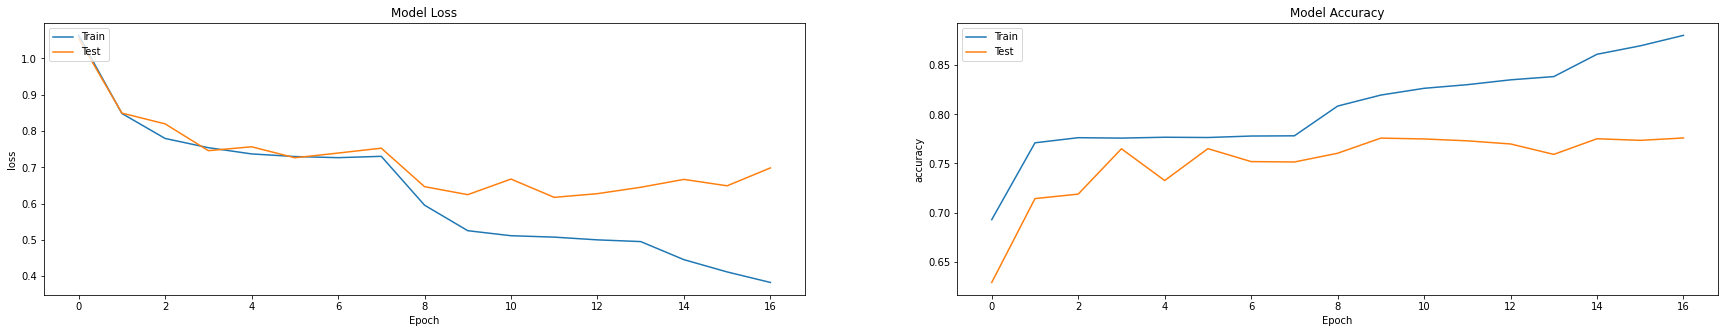

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(hitory1.history['loss'])
plt.plot(hitory1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(hitory1.history['accuracy'])
plt.plot(hitory1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model:-2

In [46]:
from tensorflow.keras import regularizers
def simple_mlp_model(input_shape):   
    model_in = Input(shape=(input_shape,), dtype='float32')
    out = Dense(2048,activation='relu',kernel_regularizer=regularizers.l2(0.001))(model_in)
    out = BatchNormalization()(out)
    out = Dropout(0.60)(out)
    out = Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = BatchNormalization()(out)
    out = Dropout(0.50)(out)
    out = Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = BatchNormalization()(out)
    out = Dropout(0.40)(out)
    out = Dense(256,activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = BatchNormalization()(out)
    out = Dropout(0.30)(out)
    out = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = BatchNormalization()(out)
    out = Dropout(0.60)(out)
    out = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = BatchNormalization()(out)
    out = Dropout(0.30)(out)
    out = Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = BatchNormalization()(out)
    out = Dropout(0.15)(out)
    out = Dense(2,activation='softmax')(out)
    model = Model(model_in, out)
    return model

In [47]:
model1=simple_mlp_model(train_s.shape[1])

In [48]:
model1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100022)]          0         
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              204847104 
_________________________________________________________________
batch_normalization_3 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0   

In [49]:
import tensorflow as tf
adam = tf.keras.optimizers.Adam()
model1.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])

In [54]:
from tensorflow.keras.callbacks import *
import os
filepath="weights_1.best.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, mode='min')
earlystop = EarlyStopping(monitor = 'val_loss',  mode="min",min_delta = 0, patience = 8,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.25, patience = 2, verbose = 1)
%reload_ext tensorboard
import datetime
logdir = os.path.join("logs_2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
callbacks = [checkpoint,reduce_lr,tensorboard,earlystop]

In [55]:
hitory1=model1.fit(x=train_s,y=Y_train,epochs=50,batch_size=1024,validation_data=(test_s, Y_test),callbacks=callbacks)

Epoch 1/50
297/297 [==============================] - 19s 64ms/step - loss: 1.0360 - accuracy: 0.7646 - val_loss: 0.9660 - val_accuracy: 0.7526

Epoch 00001: saving model to weights_1.best.hdf1
INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 2/50
297/297 [==============================] - 19s 63ms/step - loss: 1.0138 - accuracy: 0.7679 - val_loss: 1.0322 - val_accuracy: 0.7497

Epoch 00002: saving model to weights_1.best.hdf1
INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 3/50
297/297 [==============================] - 19s 63ms/step - loss: 1.0097 - accuracy: 0.7710 - val_loss: 1.0141 - val_accuracy: 0.7288

Epoch 00003: saving model to weights_1.best.hdf1
INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 4/50
297/297 [==============================] - 19s 63ms/step - loss: 0.7051 - accuracy: 0.8003 - val_loss: 0.6840 - val_accuracy: 0.7646

Epoch 00004: saving model to weights_1.best.hdf1
INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 5/50
297/297 [==============================] - 19s 63ms/step - loss: 0.6589 - accuracy: 0.8158 - val_loss: 0.7184 - val_accuracy: 0.7756

Epoch 00005: saving model to weights_1.best.hdf1
INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 6/50
297/297 [==============================] - 19s 63ms/step - loss: 0.6727 - accuracy: 0.8236 - val_loss: 0.7807 - val_accuracy: 0.7583

Epoch 00006: saving model to weights_1.best.hdf1
INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00006: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 7/50
297/297 [==============================] - 19s 63ms/step - loss: 0.5533 - accuracy: 0.8533 - val_loss: 0.6997 - val_accuracy: 0.7827

Epoch 00007: saving model to weights_1.best.hdf1
INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 8/50
297/297 [==============================] - 19s 63ms/step - loss: 0.4755 - accuracy: 0.8668 - val_loss: 0.7435 - val_accuracy: 0.7440

Epoch 00008: saving model to weights_1.best.hdf1
INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00008: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 9/50
297/297 [==============================] - 19s 63ms/step - loss: 0.4154 - accuracy: 0.8902 - val_loss: 0.7318 - val_accuracy: 0.7763

Epoch 00009: saving model to weights_1.best.hdf1
INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 10/50
297/297 [==============================] - 19s 63ms/step - loss: 0.3875 - accuracy: 0.8975 - val_loss: 0.7436 - val_accuracy: 0.7785

Epoch 00010: saving model to weights_1.best.hdf1
INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00010: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 11/50
297/297 [==============================] - 19s 63ms/step - loss: 0.3608 - accuracy: 0.9074 - val_loss: 0.7634 - val_accuracy: 0.7754

Epoch 00011: saving model to weights_1.best.hdf1
INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 12/50
297/297 [==============================] - 19s 63ms/step - loss: 0.3535 - accuracy: 0.9092 - val_loss: 0.7731 - val_accuracy: 0.7728

Epoch 00012: saving model to weights_1.best.hdf1
INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00012: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
Epoch 00012: early stopping


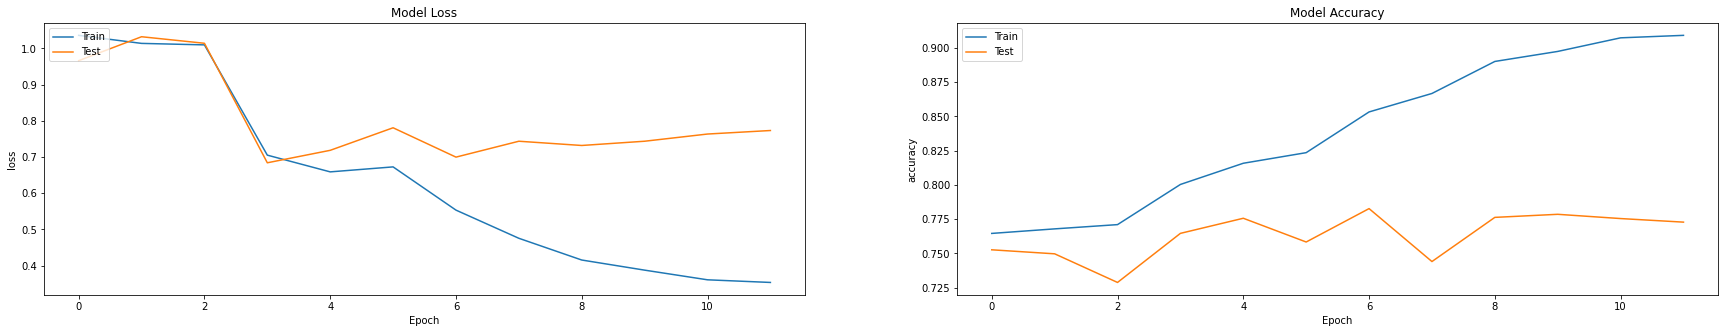

In [56]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(hitory1.history['loss'])
plt.plot(hitory1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(hitory1.history['accuracy'])
plt.plot(hitory1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [57]:
Y_pre=model.predict(test_final_s)

In [58]:
print(Y_pre)

[[9.9907136e-01 9.2856045e-04]
 [9.9138278e-01 8.6172745e-03]
 [7.6098460e-01 2.3901537e-01]
 ...
 [8.3627522e-01 1.6372484e-01]
 [8.9735901e-01 1.0264104e-01]
 [5.4776573e-01 4.5223424e-01]]


In [59]:
y_pre=model1.predict(test_final_s)

In [60]:
print(y_pre)

[[0.9825585  0.01744145]
 [0.94781584 0.05218422]
 [0.9901848  0.00981516]
 ...
 [0.9474753  0.05252471]
 [0.9941994  0.00580061]
 [0.5008927  0.4991073 ]]


In [61]:
submission=pd.read_csv('/content/gdrive/MyDrive/Case study(Quora)/quora-question-pairs/sample_submission.csv')
submission.head()

,test_id,is_duplicate
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [62]:
submission['is_duplicate']=Y_pre[:,1]

In [63]:
submission.head()

,test_id,is_duplicate
0,0,0.000929
1,1,0.008617
2,2,0.239015
3,3,0.000033
4,4,0.897166


In [64]:
submission.to_csv('submission.csv',index=False)